# softmax回归的简洁实现
:label:`sec_softmax_concise`

在 :numref:`sec_linear_concise`中，
我们发现(**通过深度学习框架的高级API能够使实现**)
(~~softmax~~)
线性(**回归变得更加容易**)。
同样，通过深度学习框架的高级API也能更方便地实现softmax回归模型。
本节如在 :numref:`sec_softmax_scratch`中一样，
继续使用Fashion-MNIST数据集，并保持批量大小为256。


In [24]:
import torch
from torch import nn
from d2l import torch as d2l

In [35]:
batch_size = 256
LR = 0.01
num_epochs = 20

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

如我们在 :numref:`sec_softmax`所述，
[**softmax回归的输出层是一个全连接层**]。
因此，为了实现我们的模型，
我们只需在`Sequential`中添加一个带有10个输出的全连接层。
同样，在这里`Sequential`并不是必要的，
但它是实现深度模型的基础。
我们仍然以均值0和标准差0.01随机初始化权重。


In [36]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    print('m : ' + str(m))
    print('------')
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        # nn.init.zeros_()

net.apply(init_weights)

m : Flatten(start_dim=1, end_dim=-1)
------
m : Linear(in_features=784, out_features=10, bias=True)
------
m : Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)
------


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## 重新审视Softmax的实现
:label:`subsec_softmax-implementation-revisited`

在前面 :numref:`sec_softmax_scratch`的例子中，
我们计算了模型的输出，然后将此输出送入交叉熵损失。
从数学上讲，这是一件完全合理的事情。
然而，从计算角度来看，指数可能会造成数值稳定性问题。

回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，
其中$\hat y_j$是预测的概率分布。
$o_j$是未规范化的预测$\mathbf{o}$的第$j$个元素。
如果$o_k$中的一些数值非常大，
那么$\exp(o_k)$可能大于数据类型容许的最大数字，即*上溢*（overflow）。
这将使分母或分子变为`inf`（无穷大），
最后得到的是0、`inf`或`nan`（不是数字）的$\hat y_j$。
在这些情况下，我们无法得到一个明确定义的交叉熵值。

解决这个问题的一个技巧是：
在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。
这里可以看到每个$o_k$按常数进行的移动不会改变softmax的返回值：

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


在减法和规范化步骤之后，可能有些$o_j - \max(o_k)$具有较大的负值。
由于精度受限，$\exp(o_j - \max(o_k))$将有接近零的值，即*下溢*（underflow）。
这些值可能会四舍五入为零，使$\hat y_j$为零，
并且使得$\log(\hat y_j)$的值为`-inf`。
反向传播几步后，我们可能会发现自己面对一屏幕可怕的`nan`结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。
通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。
如下面的等式所示，我们避免计算$\exp(o_j - \max(o_k))$，
而可以直接使用$o_j - \max(o_k)$，因为$\log(\exp(\cdot))$被抵消了。

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。
但是，我们没有将softmax概率传递到损失函数中，
而是[**在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数**]，
这是一种类似["LogSumExp技巧"](https://en.wikipedia.org/wiki/LogSumExp)的聪明方式。


In [37]:
lossfuc = nn.CrossEntropyLoss(reduction='none')

## 优化算法

在这里，我们(**使用学习率为0.1的小批量随机梯度下降作为优化算法**)。
这与我们在线性回归例子中的相同，这说明了优化器的普适性。


In [38]:
optimizer = torch.optim.SGD(net.parameters(), lr=LR)

## 训练

接下来我们[**调用**] :numref:`sec_softmax_scratch`中(~~之前~~)
(**定义的训练函数来训练模型**)。


In [39]:
for x, y in train_iter :
    
    y_hat = net(x)
    print(x.shape)
    print(y_hat.shape)
    loss = lossfuc(y_hat, y)
    print(loss.mean())
    
    break

torch.Size([256, 1, 28, 28])
torch.Size([256, 10])
tensor(2.2929, grad_fn=<MeanBackward0>)


In [40]:
num_epochs = 10
for i in range(num_epochs):
    for x, y in train_iter:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = lossfuc(y_hat, y)
        loss.mean().backward()
        optimizer.step()
        # print('Training crossentropy loss:{:.4f}'.format(loss.mean().detach().numpy()))

        
    for x_val, y_val in test_iter:
        y_pre = net(x_val)
        loss_val = lossfuc(y_pre, y_val)
        # print('Validation crossentropy loss: {:.4f}'.format(loss_val.mean().detach().numpy()))

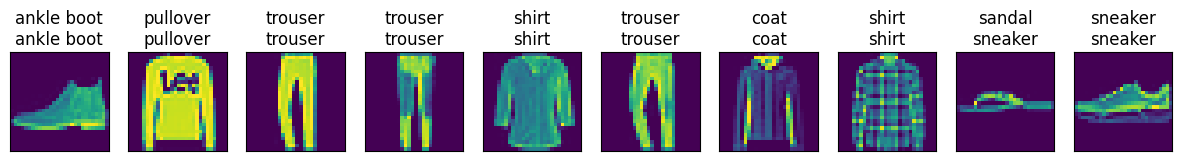

In [41]:
def predict_ch3(net, test_iter, n=10):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

In [42]:
batch_size = 256
LR = 0.01
num_epochs = 20
import torchvision.transforms as transforms

# Resize images to 64x64
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load data with transform
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# Update model input dimension
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64 * 64, 1)  # Input dimension: 4096 (64*64)
)
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
# # PyTorch不会隐式地调整输入的形状。因此，
# # 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
# net = nn.Sequential(nn.Flatten(), nn.Linear(64 * 64,10))

def init_weights(m):

    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        # nn.init.zeros_()

net.apply(init_weights)
lossfuc = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=LR)

for x, y in train_iter :
    
    y_hat = net(x)
    print(x.shape)
    print(y_hat.shape)
    loss = lossfuc(y_hat, y)
    print(loss.mean())
    
    break


for i in range(num_epochs):
    for x, y in train_iter:
        optimizer.zero_grad()
        y_hat = net(x)
        loss = lossfuc(y_hat, y)
        loss.mean().backward()
        optimizer.step()
        # print('Training crossentropy loss:{:.4f}'.format(loss.mean().detach().numpy()))

        
    for x_val, y_val in test_iter:
        y_pre = net(x_val)
        loss_val = lossfuc(y_pre, y_val)
        # print('Validation crossentropy loss: {:.4f}'.format(loss_val.mean().detach().numpy()))


def predict_ch3(net, test_iter, n=10):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x784 and 4096x1)